# Data Exploration

In [104]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as plt
import math
import numpy as np
import lightgbm as lgb

plt.rcParams['figure.dpi'] = 200

from scipy.special import expit, logit
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import auc, mean_squared_error, roc_curve, roc_auc_score

from sklearn import preprocessing

%matplotlib inline

In [63]:
dir_path = os.path.join(os.getcwd(), 'hw4_data_files')
path1 = os.path.join(dir_path,'data1.csv')
path2 = os.path.join(dir_path,'data2.csv')

data1 = pd.read_csv(path1)
data2 = pd.read_csv(path2)

data = pd.concat([data1,data2])

In [34]:
print(f"Both Data sets contains n={data1.shape[0]} samples each \nwith {data1.shape[1]} covariates, a binary treatment T, and a Y the outcome of the model")

Both Data sets contains n=4802 samples each 
with 61 covariates, a binary treatment T, and a Y the outcome of the model


In [35]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data.columns

Index(['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10',
       'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19',
       'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28',
       'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37',
       'x_38', 'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46',
       'x_47', 'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55',
       'x_56', 'x_57', 'x_58', 'T', 'Y'],
      dtype='object')

x_2, x_21, x_24, are string catagories

In [36]:
x2_val = data['x_2'].unique()
x21_val = data['x_21'].unique() 
x24_val = data['x_24'].unique()
print(f" x_2 contains {x2_val}, \n x_21 contains {x21_val}, \n x_24 contains {x24_val}")

 x_2 contains ['C' 'D' 'E' 'B' 'A' 'F'], 
 x_21 contains ['J' 'A' 'I' 'L' 'G' 'F' 'B' 'C' 'P' 'H' 'O' 'E' 'K' 'D' 'M' 'N'], 
 x_24 contains ['B' 'E' 'A' 'C' 'D']


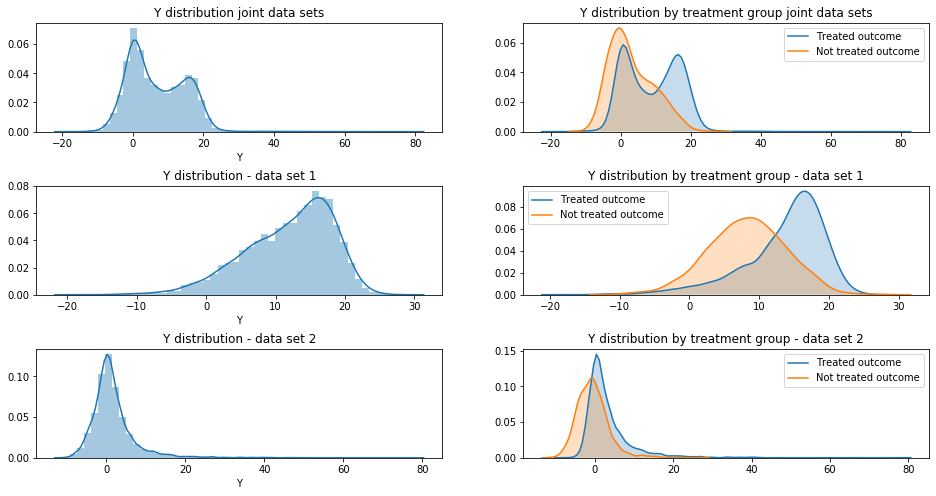

In [37]:
fig, ax = plt.subplots(nrows = 3, ncols=2, figsize=(16,8))
sns.distplot(data.Y, ax=ax[0,0])
ax[0,0].set_title('Y distribution joint data sets')
sns.kdeplot(data[data['T']==1].Y, shade=True, label='Treated outcome', ax=ax[0,1])
sns.kdeplot(data[data['T']==0].Y, shade=True, label='Not treated outcome', ax=ax[0,1])
ax[0,1].set_title('Y distribution by treatment group joint data sets')

sns.distplot(data1.Y, ax=ax[1,0])
ax[1,0].set_title('Y distribution - data set 1')
sns.kdeplot(data1[data1['T']==1].Y, shade=True, label='Treated outcome', ax=ax[1,1])
sns.kdeplot(data1[data1['T']==0].Y, shade=True, label='Not treated outcome', ax=ax[1,1])
ax[1,1].set_title('Y distribution by treatment group - data set 1')

sns.distplot(data2.Y, ax=ax[2,0])
ax[2,0].set_title('Y distribution - data set 2')
sns.kdeplot(data2[data2['T']==1].Y, shade=True, label='Treated outcome', ax=ax[2,1])
sns.kdeplot(data2[data2['T']==0].Y, shade=True, label='Not treated outcome', ax=ax[2,1])
ax[2,1].set_title('Y distribution by treatment group - data set 2')

fig.subplots_adjust(wspace=None, hspace=0.5)

In [38]:
print(f"%{(data[data['T']==1].shape[0]/data.shape[0])*100} of samples got treatment in both data sets")
print(f"%{(data1[data1['T']==1].shape[0]/data1.shape[0])*100} of samples got treatment in data1")
print(f"%{(data2[data2['T']==1].shape[0]/data2.shape[0])*100} of samples got treatment in data2")

%61.422324031653474 of samples got treatment in both data sets
%68.15910037484382 of samples got treatment in data1
%54.685547688463146 of samples got treatment in data2


In [39]:
dummy_data1 = pd.get_dummies(data1[['x_2','x_21','x_24']])
dummy_data1 = dummy_data1.reset_index()
data1_adj = data1.drop(columns=['Unnamed: 0','x_2','x_21','x_24']).reset_index()

dummy_data2 = pd.get_dummies(data2[['x_2','x_21','x_24']])
dummy_data2 = dummy_data2.reset_index()
data2_adj = data2.drop(columns=['Unnamed: 0','x_2','x_21','x_24']).reset_index()

In [40]:
data11 = pd.merge(data1_adj,dummy_data1, on='index')
data21 = pd.merge(data2_adj,dummy_data2, on='index')

In [41]:
print(f"changed 3 categorial features to one hot vectors - adding {dummy_data1.shape[1]-3} columns \ndata now contains {data11.shape[1]} features")

changed 3 categorial features to one hot vectors - adding 25 columns 
data now contains 85 features


In [42]:
data11.drop(columns=['index'],inplace=True)
data21.drop(columns=['index'],inplace=True)

In [43]:
# change categorial columns to one hot vectors

data_cols = data11.drop(columns=['T','Y'])

coefficient_diff = pd.DataFrame()
coefficient_diff['treated_mean'] = data_cols[data11['T']==1].mean()
coefficient_diff['treated_med'] = data_cols[data11['T']==1].median()
coefficient_diff['treated_std'] = data_cols[data11['T']==1].std()
coefficient_diff['not_treated_mean'] = data_cols[data11['T']==0].mean()
coefficient_diff['treated_med'] = data_cols[data11['T']==0].median()
coefficient_diff['not_treated_std'] = data_cols[data11['T']==0].std() 

print("Data 1 diffrence in covariates in treated and non-treated")
coefficient_diff

Data 1 diffrence in covariates in treated and non-treated


,treated_mean,treated_med,treated_std,not_treated_mean,not_treated_std
x_1,25.255118,24.000,5.981481,25.435579,6.055476
x_3,7.206882,0.125,10.199968,7.070471,9.759588
x_4,4.897036,3.000,5.611786,5.098430,5.730501
x_5,63.432631,63.000,2.614808,63.319817,2.579192
x_6,130.624809,126.000,24.808282,130.368869,25.588185
...,...,...,...,...,...
x_24_A,0.003972,0.000,0.062907,0.003270,0.057110
x_24_B,0.260617,0.000,0.439038,0.274689,0.446504
x_24_C,0.002444,0.000,0.049386,0.001308,0.036155
x_24_D,0.010388,0.000,0.101406,0.011772,0.107895


In [44]:
data_cols = data21.drop(columns=['T','Y'])

coefficient_diff = pd.DataFrame()
coefficient_diff['treated_mean'] = data_cols[data21['T']==1].mean()
coefficient_diff['treated_med'] = data_cols[data21['T']==1].median()
coefficient_diff['treated_std'] = data_cols[data21['T']==1].std()
coefficient_diff['not_treated_mean'] = data_cols[data21['T']==0].mean()
coefficient_diff['treated_med'] = data_cols[data21['T']==0].median()
coefficient_diff['not_treated_std'] = data_cols[data21['T']==0].std() 

print("Data 2 diffrence in covariates in treated and non-treated")
coefficient_diff

Data 2 diffrence in covariates in treated and non-treated


,treated_mean,treated_med,treated_std,not_treated_mean,not_treated_std
x_1,25.296268,24.0,6.093541,25.332261,5.897936
x_3,6.862767,0.5,9.832595,7.526310,10.320579
x_4,4.849581,3.0,5.574776,5.095818,5.737947
x_5,62.838538,64.0,2.556302,64.070312,2.499677
x_6,127.237243,130.0,24.575010,134.533088,25.057448
...,...,...,...,...,...
x_24_A,0.004950,0.0,0.070199,0.002298,0.047891
x_24_B,0.257426,0.0,0.437299,0.274357,0.446292
x_24_C,0.001523,0.0,0.039006,0.002757,0.052450
x_24_D,0.011043,0.0,0.104526,0.010570,0.102289


# Propensetiy Methods
I will try different estimation of the propensity scores:
<br> 1) Logistic regression
<br> 2) Gradient boosted decision trees
<br> 3) Neural Network
<br> 4)

In [80]:
def calc_propensity_score_sklearn_LR(X,T):

    model = LogisticRegression(max_iter=500)
    ps_model = model.fit(X=X, y=T)
    pscores = ps_model.predict_proba(X)[:,1]

    return ps_model, pscores
def calc_propensity_score_sklearn_RF(X,T):
    
    model = RandomForestClassifier(n_estimators=500, max_depth=5)
    y_model = model.fit(X,T)
    pscores = cross_val_predict(y_model,X,T,method='predict_proba',cv=5)[:,1]
    
    return y_model,pscores


def plot_pscores(datasets, titles=['propensity score of data1 LR','propensity score of data2 LR']):
    ncols = len(datasets)
    fig, ax = plt.subplots(nrows=1,ncols=ncols, figsize=plt.figaspect(0.5))
    for i, data in enumerate(datasets):      
        labels = [0,1]
        data_0 = data[data['T']==0]
        data_1 = data[data['T']==1]
        N_0 = data_0.shape[0]
        N_1 = data_1.shape[0]
        
        pscores_treated = data_1.ps
        ax[i] = sns.kdeplot(pscores_treated, shade=True, label=f'T={labels[1]} N=({N_1})', ax=ax[i])
        pscores_not_treated = data_0.ps
        ax[i] = sns.kdeplot(pscores_not_treated, shade=True, label=f'T={labels[0]} N=({N_0})', ax=ax[i])
        ax[i].set_title(titles[i])
        ax[i].legend(loc="best")

In [75]:
cols_to_drop = ['T','Y']
data1_cov = data11.drop(columns=cols_to_drop)
data2_cov = data21.drop(columns=cols_to_drop)

In [105]:
X1 = data1_cov
Y1 = data11['Y']
T1 = data11['T']
X2 = data2_cov
Y2 = data21['Y']
T2 = data11['T']

In [ ]:
ps_model1, pscores = calc_propensity_score_sklearn_RF(X=data1_cov, T=data11['T'])
data1_copy = data11.copy()
data1_copy['ps'] = pscores


ps_model2, pscores = calc_propensity_score_sklearn_RF(X=data2_cov, T=data21['T'])
data2_copy = data2.copy()
data2_copy['ps'] = pscores

In [83]:

ps_model1, pscores = calc_propensity_score_sklearn_LR(X=data1_cov, T=data11['T'])
data1_copy = data11.copy()
data1_copy['ps'] = pscores


ps_model2, pscores = calc_propensity_score_sklearn_LR(X=data2_cov, T=data21['T'])
data2_copy = data2.copy()
data2_copy['ps'] = pscores


/Users/amirgavrieli/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/amirgavrieli/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

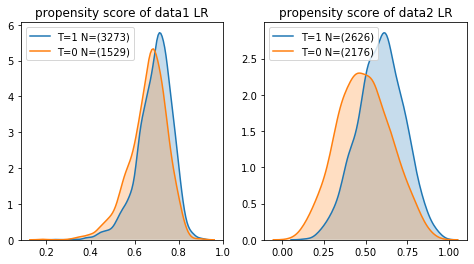

In [84]:
plot_pscores(datasets=[data1_copy,data2_copy])

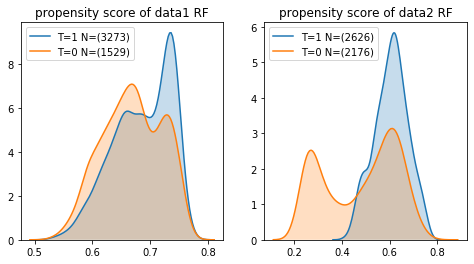

In [82]:
plot_pscores(datasets=[data1_copy,data2_copy], titles=['propensity score of data1 RF','propensity score of data2 RF'])

# Matching 

In [49]:
def find_propensity_score_matches(X, TX_col, pscore_col, caliper=0.25, distance='linear'):
    """
    Treatment group should be smaller
    """
    
    idx_A0 = X[TX_col]==0
    idx_A1 = X[TX_col]==1
    
    X_T1, X_T0 = X[idx_A1].copy(), X[idx_A0].copy()
    N1, N0 = len(X_T1), len(X_T0)
    g1, g0 = X_T1.loc[:,pscore_col].copy(),  X_T0.loc[:,pscore_col].copy()
    
    # get caliper_value (default is 0.25 logit stdevs
    caliper_value = caliper * logit(X[pscore_col]).std()

    # Randomly permute the smaller group to get order for matching
    g1_idx_order = np.random.permutation(g1.index)
    for g1_idx in g1_idx_order:
        
        if distance=='linear': # linear propensity score (on the logits)
            dist = np.abs(logit(g1[g1_idx]) - logit(g0))
        else: # regular propensity score
            dist = np.abs(g1[g1_idx] - g0)
        
        
        if dist.min() <= caliper_value:
            g0_idx = dist.idxmin()
            X_T1.loc[g1_idx, 'matched_control_idx'] = g0_idx
            X_T0.loc[g0_idx, 'matched_control_idx'] = g0_idx
            g0 = g0.drop(g0_idx)
        else:
            X_T1.loc[g1_idx, 'matched_control_idx'] = np.nan        
            
    X_matched = pd.concat([X_T1, X_T0])
    return X_matched

In [50]:
data11['ps'] = data1_copy.ps
data_matched = find_propensity_score_matches(data11, 'T', 'ps', caliper=0.25, distance='linear')

In [51]:
data_matched.dropna(subset=['matched_control_idx'],inplace=True)

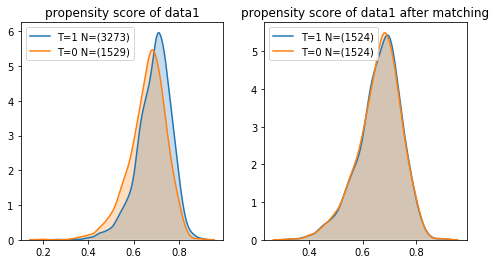

In [52]:
plot_pscores(datasets=[data11,data_matched],titles=['propensity score of data1','propensity score of data1 after matching'])

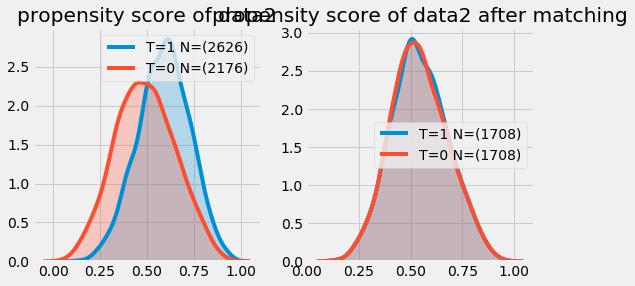

In [119]:
data21['ps'] = data2_copy.ps
data_matched2 = find_propensity_score_matches(data21, 'T', 'ps', caliper=0.25, distance='linear')
data_matched2.dropna(subset=['matched_control_idx'],inplace=True)
plot_pscores(datasets=[data21,data_matched2],titles=['propensity score of data2','propensity score of data2 after matching'])


# ATT by matching

In [131]:
data_cols

,x_1,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,...,x_21_L,x_21_M,x_21_N,x_21_O,x_21_P,x_24_A,x_24_B,x_24_C,x_24_D,x_24_E
0,29,1.0,7.0,60,85,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,27,0.0,0.0,64,178,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,27,0.0,0.0,60,102,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,37,0.0,0.0,65,174,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,24,20.0,14.0,63,129,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4797,21,0.0,0.0,67,140,0,0,2,0,0,...,0,0,0,0,0,0,1,0,0,0
4798,24,0.0,0.0,62,130,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4799,33,5.0,15.0,63,137,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4800,36,10.0,22.0,60,110,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [139]:
from causalml.match import NearestNeighborMatch, create_table_one

psm = NearestNeighborMatch(replace=False,
                           ratio=1,
                           random_state=42)

covariates = data_cols.columns.tolist()

matched = psm.match(data=data11,
                             treatment_col='T',
                             score_cols=['ps']
                             )

In [145]:
create_table_one(data=matched,
                 treatment_col='T',
                 features=covariates)

,Control,Treatment,SMD
Variable,,,
n,1523,1523,
x_1,25.44 (6.04),25.55 (6.16),0.0192
x_10,0.17 (0.72),0.16 (0.68),-0.0103
x_11,0.02 (0.21),0.03 (0.21),0.0125
x_12,0.67 (0.92),0.66 (1.01),-0.0102
...,...,...,...
x_58,39.43 (2.85),39.48 (2.77),0.018
x_6,130.43 (25.58),130.56 (24.62),0.0049
x_7,0.09 (0.41),0.09 (0.40),-0.0032


In [144]:
data11.shape

(4802, 86)

## Propensity scores using causalml package (uber)

In [116]:
from causalml.propensity import ElasticNetPropensityModel

pm = ElasticNetPropensityModel(n_fold=5, random_state=42)
ps1 = pm.fit_predict(X1, T1)
ps2 = pm.fit_predict(X2, T2)

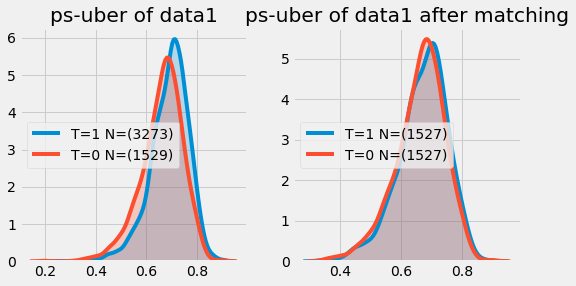

In [117]:
data11['ps_uber'] = ps1
data_matched1 = find_propensity_score_matches(data11, 'T', 'ps_uber', caliper=0.25, distance='linear')
data_matched1.dropna(subset=['matched_control_idx'],inplace=True)
plot_pscores(datasets=[data11,data_matched1],titles=['ps-uber of data1','ps-uber of data1 after matching'])


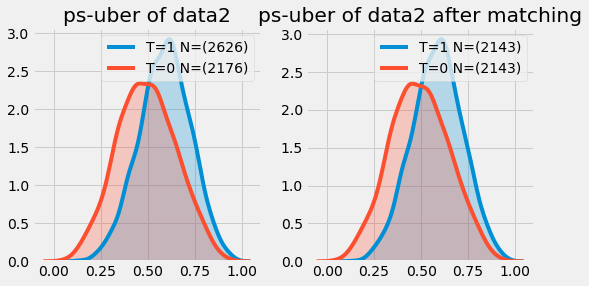

In [118]:
data21['ps_uber'] = ps2
data_matched2 = find_propensity_score_matches(data21, 'T', 'ps_uber', caliper=0.25, distance='linear')
data_matched2.dropna(subset=['matched_control_idx'],inplace=True)
plot_pscores(datasets=[data21,data_matched2],titles=['ps-uber of data2','ps-uber of data2 after matching'])


# Estimating ATT by Inverse Propensity Score Weighting (IPW)

Under ignorability for ATE we use the following formula:
\begin{equation}
\frac{1}{n}\sum_{i=1}^{n}{\frac{y_i t_i}{e_i}} - \frac{1}{n}\sum_{i=1}^{n}{\frac{y_i (1-t_i)}{1-e_i}}
\end{equation}


The weights described previously ($w_ATE= \frac{Z}{e} +\frac{1-Z}{1-e}$) permit estimation of the ATE. However, a different set of weights permit estimation of the average treatment effect in the treated (ATT): $w_ATT = Z +\frac{e \cdot(1−Z)}{1 − e}$[18]. These weights are obtained by multiplying the conventional weights by e , so that treated subjects receive a weight of one. Thus, the treated sample is being used as the reference population to which the treated and control samples are being standardized. While the current article is focused on the use of the ATE weights, the balance diagnostics discussed are equally applicable to situations in which the ATT weights are employed.

So We calculate:

\begin{equation}
\frac{1}{n}\sum_{i=1}^{n}{y_i t_i} - \frac{1}{n}\sum_{i=1}^{n}{y_i (1-t_i) \frac{e_i}{1-e_i}}
\end{equation}

In [54]:
ATE1 = (data11.Y*data11['T']*(1/data1_copy.ps)).mean() - (data11.Y*(1-data11['T'])*(1/(1-data1_copy.ps))).mean()
print(f"The estimated ATE for data1 using IPW is {ATE1}")
ATT1 = (data11.Y*data11['T']).mean() - (data11.Y*(1-data11['T'])*(data1_copy.ps/(1-data1_copy.ps))).mean()
print(f"The estimated ATT for data1 using IPW is {ATT1}")

The estimated ATE for data1 using IPW is 4.508278610497134
The estimated ATT for data1 using IPW is 2.9730169584388655


In [55]:
ATE2 = (data21.Y*data21['T']*(1/data2_copy.ps)).mean() - (data21.Y*(1-data21['T'])*(1/(1-data2_copy.ps))).mean()
print(f"The estimated ATE for data2 using IPW is {ATE2}")
ATT2 = (data21.Y*data21['T']).mean() - (data21.Y*(1-data21['T'])*(data2_copy.ps/(1-data2_copy.ps))).mean()
print(f"The estimated ATT for data2 using IPW is {ATT2}")

The estimated ATE for data2 using IPW is 3.4260361883900963
The estimated ATT for data2 using IPW is 1.935878675279306


# Estimating ATT using S-Learner

S-learner (single): fit a model with $t$ as feature on the entire sample:
\begin{equation}
y \approx \hat{f}(x,t) \\
ATT \approx \frac{1}{n}\sum_{i=1}^{n}{\hat{f}(x,1)} - \frac{1}{n}\sum_{i=1}^{n}{\hat{f}(x,0)}
\end{equation}

## S-Learner a linear approach

In [56]:
model = LinearRegression()
X = data11.drop(columns=['Y','ps'])
y = data11['Y']               
reg1 = model.fit(X,y)

In [57]:
X_treated = X[X['T']==1].copy()
X_1 = X_treated.copy()
X_1['T'] = 1
X_0 = X_treated.copy()
X_0['T'] = 0       
ATT1 = (reg1.predict(X_1) - reg1.predict(X_0)).mean()
print(f"The estimated ATT for data1 using S-Learner is {ATT1}")

The estimated ATT for data1 using S-Learner is 4.635642018972904


In [58]:
X = data21.drop(columns=['Y','ps'])
y = data21['Y']               
reg2 = model.fit(X,y)

In [59]:
X_treated = X[X['T']==1].copy()
X_1 = X_treated.copy()
X_1['T'] = 1
X_0 = X_treated.copy()
X_0['T'] = 0       
ATT2 = (reg1.predict(X_1) - reg1.predict(X_0)).mean()
print(f"The estimated ATT for data2 using S-Learner is {ATT2}")

The estimated ATT for data2 using S-Learner is 3.123800637335524


In [102]:
mean_squared_error(y,reg1.predict(X))

22.03021830387998

# S-Learner Tree

## Random Forest

In [91]:
model = RandomForestRegressor(n_estimators=500,max_depth=5)
model_y = model.fit(X,y)

In [92]:
(model_y.predict(X_1)-model_y.predict(X_0)).mean()

2.1051962125934627

In [103]:
mean_squared_error(y,model_y.predict(X))

3.0763922778446444

# causalml (Uber)

From https://github.com/uber/causalml

In [106]:
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import BaseRRegressor
from xgboost import XGBRegressor

/Users/amirgavrieli/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/amirgavrieli/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/Users/amirgavrieli/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: F

In [121]:
from causalml.dataset import synthetic_data

y, X, treatment, _, _, e = synthetic_data(mode=1, n=1000, p=5, sigma=1.0)

In [108]:
lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))


Average Treatment Effect (Linear Regression): 0.53 (0.38, 0.68)


In [122]:
te

array([0.52959365])

In [123]:
from causalml.match import NearestNeighborMatch